In [3]:
import os
import sys
sys.path.append(os.getcwd()+"/../..")
from src import paths
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
import numpy as np
from huggingface_hub import notebook_login
import tqdm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [134]:
# Login to Hugging Face Hub as model is gated
notebook_login()

In [4]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load Data
df = pl.read_csv(os.path.join(paths.DATA_PATH_PREPROCESSED, "line_labelling_clean.csv"))
num_labels = len(df['class_agg'].unique())

# Checkpoint
checkpoint = "GerMedBERT/medbert-512"

# Load model
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Load model for embedding
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels).to(device)

In [3]:
torch.cuda.empty_cache()
print(f"GPU Memory Allocated: {torch.cuda.memory_allocated() / 1024**2} MB")
print(f"GPU Memory Cached: {torch.cuda.memory_reserved() / 1024**2} MB")
print(torch.cuda.memory_summary())

GPU Memory Allocated: 416.75634765625 MB
GPU Memory Cached: 470.0 MB
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 426758 KiB | 426758 KiB | 426758 KiB |      0 B   |
|       from large pool | 426240 KiB | 426240 KiB | 426240 KiB |      0 B   |
|       from small pool |    518 KiB |    518 KiB |    518 KiB |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         | 426758 KiB | 426758 KiB | 426758 KiB |      0 B

In [8]:
# No need to rerun if embeddings saved
# Embed data while logging progress
embeddings = []
embeddings_base = []
batch_size = 16

for i in tqdm.tqdm(range(0, len(df), batch_size)):
    tokens = tokenizer(df['text'][i:i+batch_size].to_list(), padding=True, truncation=True, return_tensors="pt").to(device)
    attention_mask = tokens["attention_mask"][i:i+batch_size]
    with torch.no_grad():
        embeddings.append(model(**tokens, output_hidden_states=True).hidden_states[-1].cpu())
        embeddings_base.append(model.base_model(**tokens).pooler_output.cpu())

# Save embeddings
torch.save(embeddings, os.path.join(paths.DATA_PATH_PREPROCESSED, "line-label_pred/embeddings.pt"))
torch.save(embeddings_base, os.path.join(paths.DATA_PATH_PREPROCESSED, "line-label_pred/embeddings_base.pt"))

100%|██████████| 120/120 [00:16<00:00,  7.35it/s]


The embeddings are stored in shape batch_size X sequence_length x embedding_size. Multiple ways to construct embeddings now:
- Mean over sequence
- CLS [:,0,:] token
- Pooling of CLS tokens (in embeddings_base)

In [2]:
# Load embeddings
embeddings = torch.load(os.path.join(paths.DATA_PATH_PREPROCESSED, "embeddings.pt"))

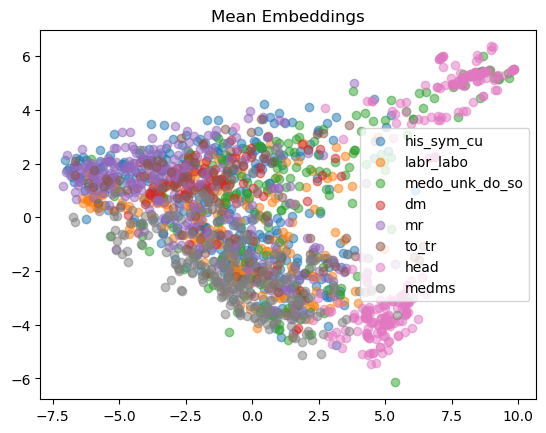

In [5]:
# Mean over sequence
embeddings_mean = [torch.mean(embedding, dim=1) for embedding in embeddings]
embeddings_mean = torch.cat(embeddings_mean, dim=0)

# Plot Mean Embeddings
plot_embeddings(embeddings_mean, df["class_agg"], title="Mean Embeddings", method="pca")

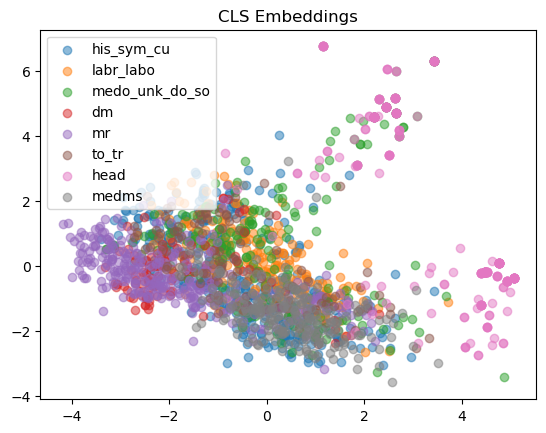

In [6]:
# Plot CLS embeddings
embeddings_cls = [embedding[:,0,:] for embedding in embeddings]
embeddings_cls = torch.cat(embeddings_cls, dim=0)
plot_embeddings(embeddings_cls, df["class_agg"], title="CLS Embeddings", method="pca")

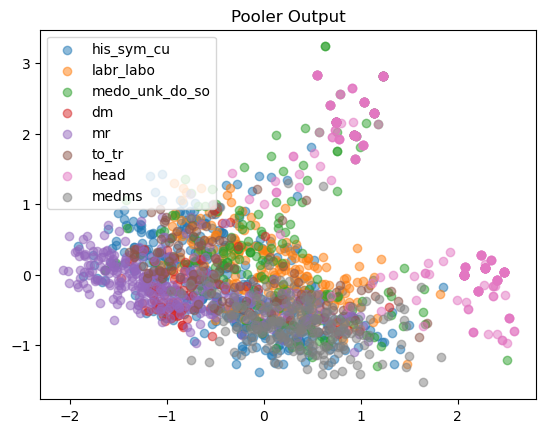

In [7]:
# Pool Embeddings
embeddings_base = torch.load(os.path.join(paths.DATA_PATH_PREPROCESSED, "embeddings_base.pt"))
embeddings_base = torch.cat(embeddings_base, dim=0)
plot_embeddings(embeddings_base, df["class_agg"], title="Pooler Output", method="pca")

In [38]:
print("Hidden State [-1] model is equal Hidden State [-1] base_model:", torch.equal(output.hidden_states[-1], output_base.hidden_states[-1]))
print("Hidden State [-1] model is equal base_model last_hidden_state:", torch.equal(output.hidden_states[-1], output_base.last_hidden_state))
print("Hidden State [-1] model is equal base_model pooler_output:", torch.equal(output.hidden_states[-1], output_base.pooler_output))

Hidden State [-1] model is equal Hidden State [-1] base_model: True
Hidden State [-1] model is equal base_model last_hidden_state: True
Hidden State [-1] model is equal base_model pooler_output: False


My understanding:
- AutoModelForSequenceClassification will add a pooling layer (weights and bias with tanh) and a classification head (weights and bias). In the model config there is no pooling layer specified. 
- The Model for Masked Sequence did not have a pooling layer, but when calling AutoModel this pooling layer config is set to true automatically even though it is not listed in the config, it is the default I think.
- I think I will fine-tune the model normally then use the base model to get the pooled embeddings and visualize that. I need to figure out if the model actually makes use of the pooled embeddings or if it directly uses the last hidden layer.

Question:
- Will the pooling layer be trained as well?
- Is the prediction based on the pooling layer?